In [28]:
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
# Thêm thư mục gốc dự án vào Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Đã thêm thư mục gốc dự án vào sys.path: {project_root}")

# Import các hàm
from src import load_data, plot_target_distribution, plot_missing_values, plot_univariate_distribution, plot_correlation_heatmap
import numpy as np

# **1. Tải & Kiểm tra Cấu trúc Dữ liệu (Load & Inspect)**

- Load file aug_train.csv và in ra 5 dòng đầu, kích thước (shape), và kiểu dữ liệu (dtypes).
- Dữ liệu có bao nhiêu dòng, bao nhiêu cột?
- Các cột tên là gì? Cột nào là số (numerical), cột nào là chữ (categorical)?
- Cột nào là nhãn cần dự đoán (target)?

In [17]:
PATH_TRAIN = '../data/raw/aug_train.csv' 
data, header, field_map = load_data(PATH_TRAIN)
print(f"Kích thước dữ liệu (Số dòng, Số cột): ({data.shape[0]}, {len(header)})")
numerical_cols = []
categorical_cols = []
for col_name in header:
    col_dtype = data[field_map[col_name]].dtype
    if np.issubdtype(col_dtype, np.number):
        numerical_cols.append(col_name)
    else:
        categorical_cols.append(col_name)

print(f"Danh sách cột SỐ ({len(numerical_cols)}):")
print(numerical_cols)

print(f"Danh sách cột CHỮ/PHÂN LOẠI ({len(categorical_cols)}):")
print(categorical_cols)

target_col = 'target'
if target_col in header:
    print(f"Cột nhãn cần dự đoán (Target): '{target_col}'")
else:
    print("Cảnh báo: Không tìm thấy cột 'target' trong dữ liệu này.")

# In 5 dòng đầu tiên
print("\n--- 5 DÒNG ĐẦU TIÊN ---")
for i in range(5):
    print(f"{data[i]}")

Kích thước dữ liệu (Số dòng, Số cột): (19158, 14)
Danh sách cột SỐ (4):
['enrollee_id', 'city_development_index', 'training_hours', 'target']
Danh sách cột CHỮ/PHÂN LOẠI (10):
['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']
Cột nhãn cần dự đoán (Target): 'target'

--- 5 DÒNG ĐẦU TIÊN ---
(8949, 'city_103', 0.92, 'Male', 'Has relevent experience', 'no_enrollment', 'Graduate', 'STEM', '>20', '', '', '1', 36, 1.)
(29725, 'city_40', 0.776, 'Male', 'No relevent experience', 'no_enrollment', 'Graduate', 'STEM', '15', '50-99', 'Pvt Ltd', '>4', 47, 0.)
(11561, 'city_21', 0.624, '', 'No relevent experience', 'Full time course', 'Graduate', 'STEM', '5', '', '', 'never', 83, 0.)
(33241, 'city_115', 0.789, '', 'No relevent experience', '', 'Graduate', 'Business Degree', '<1', '', 'Pvt Ltd', 'never', 52, 1.)
(666, 'city_162', 0.767, 'Male', 'Has relevent experience', 'no_enrollment'

# **2. Phân tích Biến Mục tiêu (Target Analysis)**

- Đếm số lượng và vẽ biểu đồ cột cho biến target (0 và 1).
- Tỷ lệ giữa người muốn đổi việc (1) và người không (0) là bao nhiêu?
- Có bị mất cân bằng lớp (Imbalanced Class) không? (Ví dụ: 90% lớp 0 và chỉ 10% lớp 1 là mất cân bằng nặng => Cần lưu ý khi chọn độ đo đánh giá như F1-Score thay vì Accuracy).

Tổng số mẫu: 19158
- Số người KHÔNG đổi việc (0): 14381 (75.07%)
- Số người MUỐN đổi việc (1): 4777 (24.93%)


d:\_STUDY\LTKHDL\Lab\HW02\HR-Analytics-Job-Change-of-Data-Scientists\src\visualization.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette='viridis')


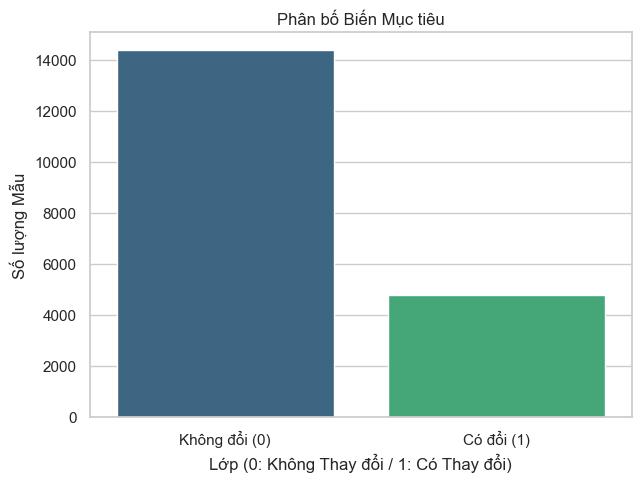

In [18]:
# Lấy cột Target
targets = data[field_map['target']]

# Tính toán tỷ lệ
count_1 = np.sum(targets == 1.0)
count_0 = np.sum(targets == 0.0)
total = len(targets)
ratio_1 = count_1 / total * 100

print(f"Tổng số mẫu: {total}")
print(f"- Số người KHÔNG đổi việc (0): {count_0} ({100 - ratio_1:.2f}%)")
print(f"- Số người MUỐN đổi việc (1): {count_1} ({ratio_1:.2f}%)")

# Vẽ biểu đồ
plot_target_distribution(targets, labels=['Không đổi (0)', 'Có đổi (1)'])

**Nhận định:**
* Dữ liệu có sự **mất cân bằng lớp (Class Imbalance)**: Lớp 0 chiếm khoảng 75%, trong khi lớp 1 chỉ chiếm 25%.
* **Khuyến nghị:** Khi đánh giá mô hình, không nên chỉ dựa vào độ chính xác (Accuracy). Cần quan tâm đến các chỉ số như **Precision, Recall** và **F1-Score** để đảm bảo mô hình dự đoán tốt cho lớp thiểu số (người muốn đổi việc).

Tỷ lệ giá trị thiếu theo cột:
enrollee_id: 0.00%
city: 0.00%
city_development_index: 0.00%
gender: 23.53%
relevent_experience: 0.00%
enrolled_university: 2.01%
education_level: 2.40%
major_discipline: 14.68%
experience: 0.34%
company_size: 30.99%
company_type: 32.05%
last_new_job: 2.21%
training_hours: 0.00%
target: 0.00%


d:\_STUDY\LTKHDL\Lab\HW02\HR-Analytics-Job-Change-of-Data-Scientists\src\visualization.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percentages, y=cols, palette='Reds_d')


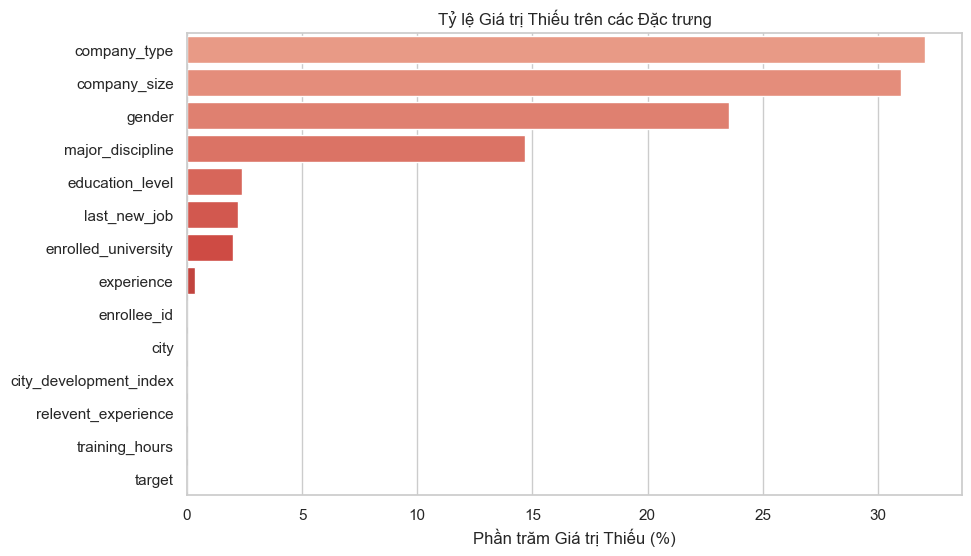

In [19]:
# Tạo dictionary missing_percentages
missing_percentages = {}

# Duyệt qua các cột (field_map)
for col_name, field_name in field_map.items():
    column = data[field_name]
    
    # Đếm giá trị thiếu (chuỗi rỗng hoặc NaN)
    if column.dtype.kind in ['U', 'S', 'O']:  # String hoặc Object
        missing_count = np.sum(column == '')
    else:  # Numeric
        missing_count = np.sum(np.isnan(column.astype(float)))
    
    # Tính phần trăm
    missing_percent = (missing_count / len(column)) * 100
    missing_percentages[col_name] = missing_percent

print("Tỷ lệ giá trị thiếu theo cột:")
for col, percent in missing_percentages.items():
    print(f"{col}: {percent:.2f}%")

plot_missing_values(missing_percentages)

**Nhận định:**
* Các cột **`company_type`** và **`company_size`** thiếu dữ liệu rất lớn (khoảng 30%). Cột `gender` thiếu khoảng 23%.
* **Giải pháp:** Trong bước tiền xử lý (Preprocessing), chúng ta sẽ điền giá trị thiếu của các cột danh mục bằng một nhãn riêng là **'Unknown'** để giữ lại thông tin về việc thiếu dữ liệu này (có thể do ứng viên thất nghiệp hoặc mới ra trường).

### 4. Trả lời Câu hỏi Nghiên cứu (Analysis & Insights)

Chúng ta sẽ tập trung phân tích 2 biến số quan trọng nhất:
1.  **`city_development_index`**: Chỉ số phát triển của thành phố.
2.  **`training_hours`**: Số giờ đào tạo đã hoàn thành.

--- Phân bố: City Development Index ---


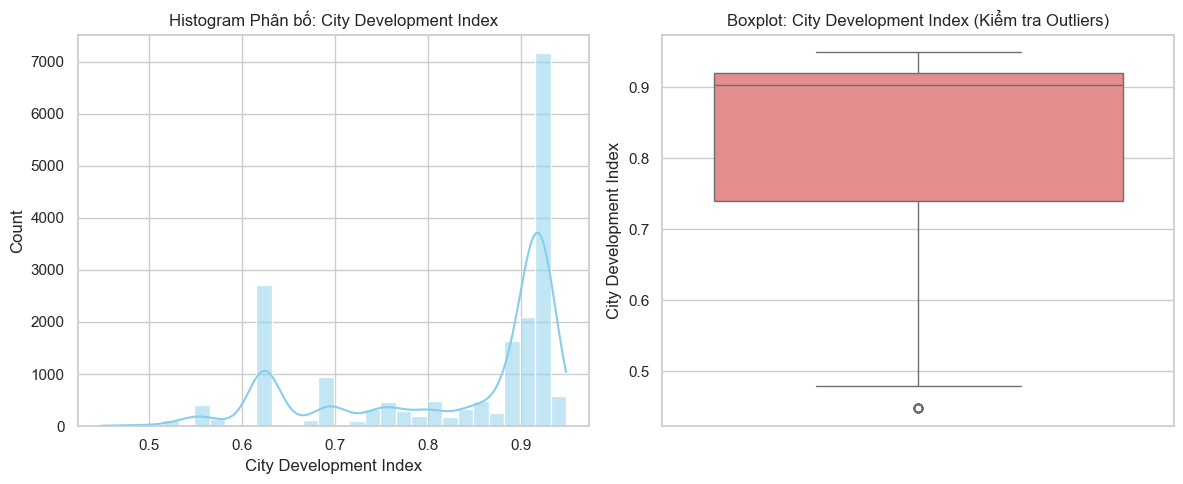

C:\Users\chiph\AppData\Local\Temp\ipykernel_13204\1506677770.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=targets, y=city_dev, palette='coolwarm')


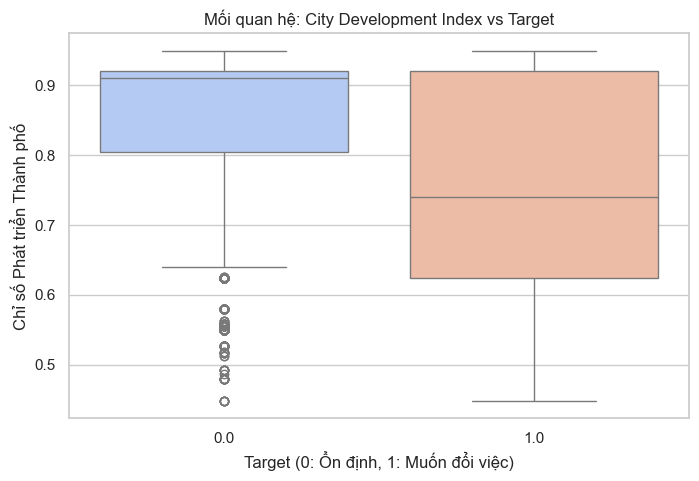

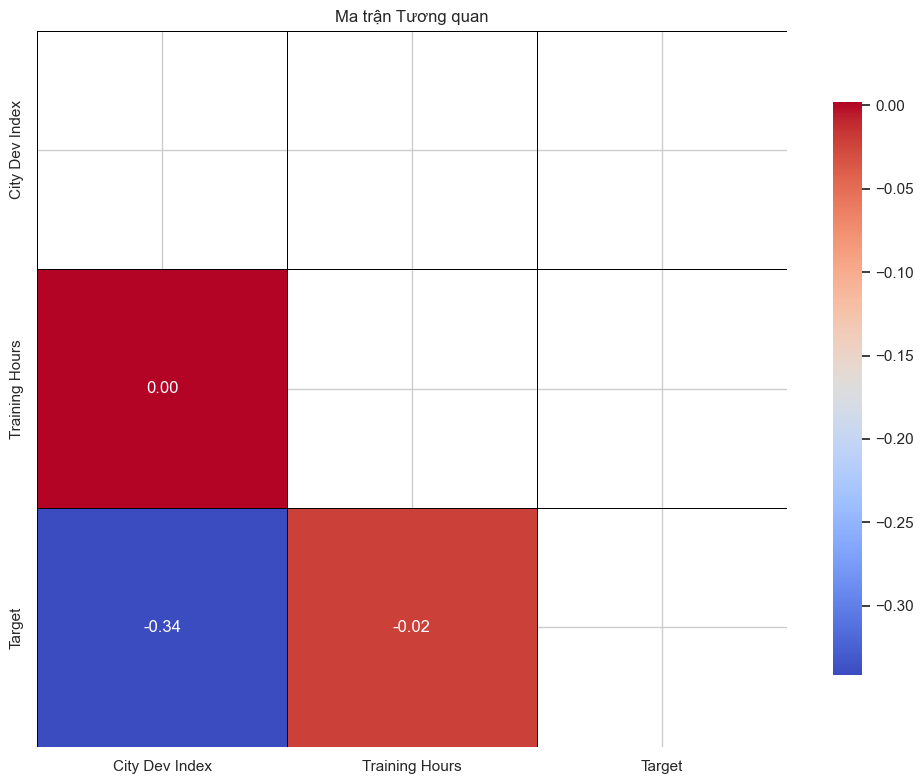

In [29]:
# --- 1. Phân tích Đơn biến (Histogram & Boxplot) ---
city_dev = data[field_map['city_development_index']]
# Lọc NaN để vẽ biểu đồ
valid_city_dev = city_dev[~np.isnan(city_dev)]

print("--- Phân bố: City Development Index ---")
plot_univariate_distribution(valid_city_dev, 'City Development Index')


# --- 2. Phân tích Đa biến: City Index ảnh hưởng thế nào đến Target? ---
# Vẽ Boxplot so sánh phân bố City Index giữa 2 nhóm Target
plt.figure(figsize=(8, 5))
sns.boxplot(x=targets, y=city_dev, palette='coolwarm')
plt.title('Mối quan hệ: City Development Index vs Target')
plt.xlabel('Target (0: Ổn định, 1: Muốn đổi việc)')
plt.ylabel('Chỉ số Phát triển Thành phố')
plt.show()


# --- 3. Heatmap Tương quan (Correlation) ---
hours_data = data[field_map['training_hours']]

# Tạo mask để lọc các hàng có NaN trong bất kỳ cột nào
mask_valid = (~np.isnan(city_dev)) & (~np.isnan(targets))

# Gom lại thành ma trận 2D để tính tương quan
X_corr = np.column_stack([
    city_dev[mask_valid], 
    hours_data[mask_valid], 
    targets[mask_valid]
])

feature_names = ['City Dev Index', 'Training Hours', 'Target']
plot_correlation_heatmap(X_corr, feature_names=feature_names, title="Ma trận Tương quan")